In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gym
from torch import nn
import epsilon_greedy
import random_agent
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Union
import collections
import copy
import time
import environment_executions as ee
from base_agent import agent_template
from policy_gradient import pg_model

In [3]:
desc = ["SFFH", "FHFF", "FFFF", "HFFG"]
env = gym.make('FrozenLake-v1', is_slippery=True, desc=desc)
env = gym.make('Blackjack-v1')

True

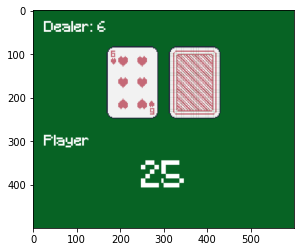

In [4]:
obs, info = env.reset(return_info=True)

def show_snapshot():
    env_screen = env.render(mode = 'rgb_array')
    env.close()
    plt.imshow(env_screen)

_, _, done, info = env.step(1) # Right
_, _, done, info = env.step(0) # Left
_, _, done, info = env.step(1) # Down

show_snapshot()
done

In [19]:

def moving_average(x, window_length: Union[int, None] = None) -> np.array:
    if window_length is None:
        window_length = len(x) // 50
    return np.convolve(x, np.ones(window_length), "valid") / window_length


def plot_results(test_rewards):
    ma_rewards = moving_average(test_rewards)
    plt.plot(ma_rewards, label="rewards")
    plt.show()


def train_and_plot(agent, execution: ee.executions, env: gym.Env = env, training_epochs: int = 1000, test_epochs: int = 2500, verbose: bool =True) -> None:
    train_rewards, train_actions = execution.execute_env(agent, env=env, n_epochs=training_epochs, train=True, verbose=verbose)
    print(f'mean train reward {sum(train_rewards) / len(train_rewards):.2f}')
    #print('train actions:', dict(collections.Counter(train_actions)))
    #print('train rewards:', dict(collections.Counter(train_rewards)))
    plot_results(train_rewards)
    test_rewards, test_actions = execution.execute_env(agent, env=env, n_epochs=test_epochs, train=False, verbose=False)
    # plot_results(test_rewards)
    print('mean test rewards:', sum(test_rewards) / len(test_rewards))
    # print('mean test rewards:', dict(collections.Counter(test_rewards)))
    print('\n\n')



Next agent:
mean train reward -0.16


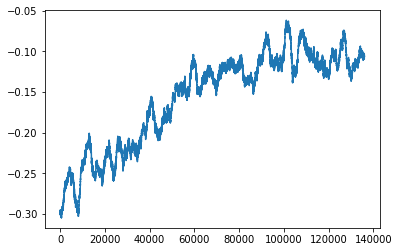

mean test rewards: -0.09378124375124974




Next agent:
mean train reward -0.19


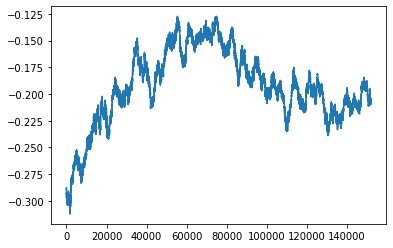

mean test rewards: -0.20015148646089756




Next agent:
mean train reward -0.26


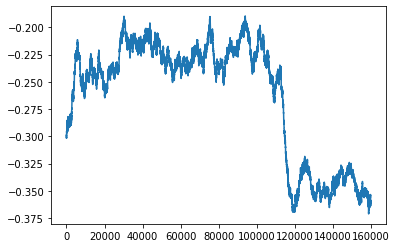

mean test rewards: -0.34114147611080126





In [34]:

n_obs = 32+11+2 # env.observation_space.n
n_actions = env.action_space.n  # Not sure how to programatically get this

network1 = nn.Sequential(nn.Linear(n_obs, n_obs * 3), nn.ReLU(), nn.Linear(n_obs * 3, n_actions))

network2 = nn.Sequential(
    nn.Linear(n_obs, n_obs * 5), nn.ReLU(), nn.Linear(n_obs * 5, n_obs * 2), nn.ReLU(), nn.Linear(n_obs * 2, n_actions)
)

basic_network = nn.Sequential(nn.Linear(n_obs, n_actions))

n_epochs = 1e5
min_epsilon = 0.1
epsilon_decay = min_epsilon ** (1 / (n_epochs + 1e-5))
lr = 1e-5
alpha = 1e-3
eg_agent1 = epsilon_greedy.eg_model(network1, n_actions, epsilon_decay=epsilon_decay, lr=lr, alpha=alpha)
eg_agent2 = epsilon_greedy.eg_model(network2, n_actions, epsilon_decay=epsilon_decay, lr=lr, alpha=alpha)
basic_bitch = epsilon_greedy.eg_model(basic_network, n_actions, epsilon_decay=epsilon_decay, lr=5e-4, alpha=alpha)
rand_agent = random_agent.random_agent(n_actions)

agents = (
    eg_agent1,
    eg_agent2,
    basic_bitch,
    #nrad_agent,
)
exe = ee.basic_execution()
for agent in agents:
    print('\nNext agent:')
    train_and_plot(agent, execution=exe, training_epochs=int(n_epochs), test_epochs=3000, verbose=False)



Next agent:
epoch: 0epoch: 200000epoch: 400000epoch: 600000epoch: 800000mean train reward -0.22


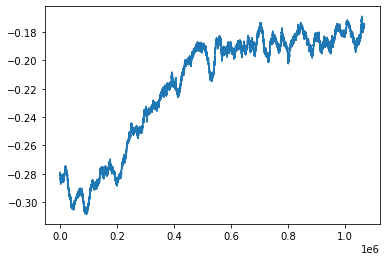

mean test rewards: -0.1984





In [37]:
import importlib
importlib.reload(ee)
n_obs = 32+11+2 # env.observation_space.n
n_actions = env.action_space.n  # Not sure how to programatically get this

network1 = nn.Sequential(nn.Linear(n_obs, n_obs * 10), nn.ReLU(), nn.Linear(n_obs * 10, n_actions), nn.Softmax(dim=-1))

basic_network = nn.Sequential(nn.Linear(n_obs, n_actions))

n_epochs = 1e6
lr = 1e-6
pg_model1 = pg_model(network1, n_actions, lr=lr)

agents = (
    pg_model1,
)
exe = ee.policy_execution()
for agent in agents:
    print('\nNext agent:')
    train_and_plot(agent, execution=exe, training_epochs=int(n_epochs), test_epochs=5000, verbose=True)


TODO:
- add a min & max epsilon + a decay rate instead, will work much better
- Add poliy gradient REINFORCE
- Pick a better ai gym that you can visualise maybe
    - the ai gym enviroment should BE piss easy to solve / do well at
        - preferably with a non trivial solution?
- Consider moving some stuff out of functions for testing - too many functions for an unfinished product (hard to debug)
- Add replay experiences (buffer n that)
- Add frozen training nuereal network, update every c epochs
